In [5]:
using Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Flux
using Base.Iterators: repeated
using MLDatasets
using Plots

#using CuArrays if you want to use GPU

In [6]:
# Load the data
x_train, y_train = MLDatasets.MNIST.traindata()
x_valid, y_valid = MLDatasets.MNIST.testdata()
# Add the channel layer
x_train = Flux.unsqueeze(x_train, 3)
x_valid = Flux.unsqueeze(x_valid, 3)
# Encode labels
y_train = onehotbatch(y_train, 0:9)
y_valid = onehotbatch(y_valid, 0:9)

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [7]:
# Create the full dataset
train_data = Flux.DataLoader((x_train, y_train), batchsize=128);

In [8]:
model = Chain(
    # 28x28 => 14x14
    Conv((5, 5), 1=>8, pad=2, stride=2, relu),
    # 14x14 => 7x7
    Conv((3, 3), 8=>16, pad=1, stride=2, relu),
    # 7x7 => 4x4
    Conv((3, 3), 16=>32, pad=1, stride=2, relu),
    # 4x4 => 2x2
    Conv((3, 3), 32=>32, pad=1, stride=2, relu),
    
    # Average pooling on each width x height feature map
    GlobalMeanPool(),
    flatten,
    
    Dense(32, 10),
    softmax)

Chain(
  Conv((5, 5), 1 => 8, relu, pad=2, stride=2),  # 208 parameters
  Conv((3, 3), 8 => 16, relu, pad=1, stride=2),  # 1_168 parameters
  Conv((3, 3), 16 => 32, relu, pad=1, stride=2),  # 4_640 parameters
  Conv((3, 3), 32 => 32, relu, pad=1, stride=2),  # 9_248 parameters
  GlobalMeanPool(),
  Flux.flatten,
  Dense(32, 10),                        # 330 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 15_594 parameters, 62.445 KiB.

In [32]:
loss_vector = Vector{Float32}()

Float32[]

In [54]:
loss(x, y) = crossentropy(model(x), y) 
opt = ADAM(); # popular stochastic gradient descent variant
accuracy(ŷ, y) = mean(onecold(ŷ) .== onecold(y))

accuracy (generic function with 1 method)

In [63]:
cb = function()
    @show(loss(x_train, y_train))
    push!(loss_vector, loss(x_train, y_train)) # callback to show loss
end

#19 (generic function with 1 method)

In [64]:
#only one epoch
Flux.train!(loss, params(model), train_data, opt, cb = throttle(cb, 10)); #took me ~5 minutes to train on CPU

loss(x_train, y_train) = 0.033581298f0


LoadError: UndefVarError: epoch not defined

In [37]:
loss_vector = Vector{Float32}()
using Flux: @epochs
number_epochs = 10

@epochs number_epochs Flux.train!(loss, params(model), train_data, opt, cb = throttle(cb, 10));

┌ Info: Epoch 1
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.039914362f0
loss(x_train, y_train) = 0.037166327f0
loss(x_train, y_train) = 0.03710796f0


┌ Info: Epoch 2
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.036577962f0
loss(x_train, y_train) = 0.035938393f0
loss(x_train, y_train) = 0.03601216f0


┌ Info: Epoch 3
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.03487561f0
loss(x_train, y_train) = 0.033907507f0
loss(x_train, y_train) = 0.032398872f0


┌ Info: Epoch 4
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.03305437f0
loss(x_train, y_train) = 0.03248217f0
loss(x_train, y_train) = 0.030697536f0
loss(x_train, y_train) = 0.030584708f0


┌ Info: Epoch 5
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.033062167f0
loss(x_train, y_train) = 0.029907264f0
loss(x_train, y_train) = 0.02586761f0
loss(x_train, y_train) = 0.04191599f0


┌ Info: Epoch 6
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.030708179f0
loss(x_train, y_train) = 0.028833525f0
loss(x_train, y_train) = 0.027637236f0
loss(x_train, y_train) = 0.04163788f0


┌ Info: Epoch 7
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.029345809f0
loss(x_train, y_train) = 0.027717289f0
loss(x_train, y_train) = 0.026872747f0
loss(x_train, y_train) = 0.03401498f0


┌ Info: Epoch 8
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.031031681f0
loss(x_train, y_train) = 0.026336145f0
loss(x_train, y_train) = 0.026465487f0
loss(x_train, y_train) = 0.025413202f0


┌ Info: Epoch 9
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.02606976f0
loss(x_train, y_train) = 0.030141035f0
loss(x_train, y_train) = 0.022542423f0
loss(x_train, y_train) = 0.028606782f0


┌ Info: Epoch 10
└ @ Main C:\Users\joaof\.julia\packages\Flux\Zz9RI\src\optimise\train.jl:138


loss(x_train, y_train) = 0.025679233f0
loss(x_train, y_train) = 0.026533121f0
loss(x_train, y_train) = 0.023749458f0
loss(x_train, y_train) = 0.02348092f0
loss(x_train, y_train) = 0.036273994f0


In [ ]:
accuracy(model(x_train), y_train)

In [ ]:
accuracy(model(x_valid), y_valid)

In [38]:
#not so easy to get vector with the throttle due to number of elements per each
loss_vector


42-element Vector{Float32}:
 0.043970678
 0.039934594
 0.042436354
 0.04153671
 0.039914362
 0.037166327
 0.03710796
 0.036577962
 0.035938393
 0.03601216
 0.03487561
 0.033907507
 0.032398872
 ⋮
 0.026336145
 0.026465487
 0.025413202
 0.02606976
 0.030141035
 0.022542423
 0.028606782
 0.025679233
 0.026533121
 0.023749458
 0.02348092
 0.036273994

This way we could make a plot on how our loss changes while training. But here our callback makes predictions on all the training data on each batch so It's not the most efficient way for the long run.

It would be better to look at our loss on each epoch. For that we will create a custom training loop.



In [ ]:
plot(1:42, loss_vector, legend=false)

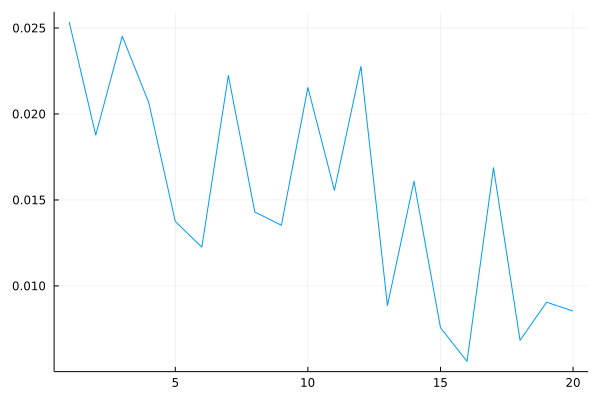

In [69]:
epochs = 20
epochs_loss_list = Vector{Float64}()

for epoch in 1:epochs
    println("epoch nr: ",epoch)
    for batch in train_data
    
        gradient = Flux.gradient(params(model)) do
          training_loss = loss(batch...)
          return training_loss
        end

        Flux.update!(opt, params(model), gradient)
    end
    
    push!(epochs_loss_list, loss(x_train, y_train))
    IJulia.clear_output(true) #This will clear the output before plotting next epoch.
    display(plot(1:epoch, epochs_loss_list, legend=false)) #builds on the go
end

In [70]:
accuracy(model(x_train), y_train)

0.9971666666666666

In [71]:
accuracy(model(x_valid), y_valid)

0.9854